# Milestone 2

---

Milestones ini dibuat guna mengevaluasi pembelajaran pada Hacktiv8 Data Science Full Time Program Phase 2 khususnya pada Deep Learning.

## Introduction

By [Rifky Aliffa](https://github.com/Penzragon)

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg/1200px-The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg)

### Dataset

Pada project ini dataset yang digunakan adalah berbagai macam gambar kebakaran dan api. Dataset dapat dilihat di [Kaggle](https://www.kaggle.com/datasets/phylake1337/fire-dataset).

### Objectives

**Milestones 2** ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

Dan tujuan utama dari project ini adalah untuk membuat model CNN yang mampu mendeteksi **kebakaran**.

## Import Libraries

Pada project ini library yang akan digunakan adalah **Pandas**, **Numpy**, **Matplotlib**, **Seaborn**, **Tensorflow**, **Keras**, dan **Scikit-Learn**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

Melakukan setting terhadap `tensorflow-gpu`.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Data Loading

In [3]:
# Create an empty dataframe
fire = pd.DataFrame(columns=['image', 'width', 'height', 'label'])

# Loop through the training data (fire images)
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

# Loop through the training data (non-fire images)
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

# Loop through the testing data (fire images)
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

# Loop through the testing data (non-fire images)
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

In [4]:
fire.head()

,image,width,height,label
0,dataset/fire_dataset/train/fire\fire.152.png,1024,683,fire
1,dataset/fire_dataset/train/fire\fire.153.png,958,641,fire
2,dataset/fire_dataset/train/fire\fire.154.png,500,333,fire
3,dataset/fire_dataset/train/fire\fire.155.png,940,470,fire
4,dataset/fire_dataset/train/fire\fire.156.png,880,495,fire


### Data Characteristics

In [5]:
fire.shape

(1461, 4)

Jumlah gambar yang terdapat pada dataset ini ada sebanyak **1462 gambar RGB**.

In [6]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1461 non-null   object
 1   width   1461 non-null   object
 2   height  1461 non-null   object
 3   label   1461 non-null   object
dtypes: object(4)
memory usage: 45.8+ KB


Dari basic information diatas dapat diketahui tipe data kolom `width` dan `height` masih bertipe **object**, maka akan dilakukan pengubahan tipe data menjadi **integer**.

## Data Cleaning

### Convert Data Types

Pada bagian ini akan dilakukan pengubahan tipe data dari kolom `width` dan `height` menjadi integer untuk mempermudah eksplorasi data,

In [7]:
fire['width'] = fire['width'].astype(int)
fire['height'] = fire['height'].astype(int)

## Exploratory Data Analysis (EDA)

### Label

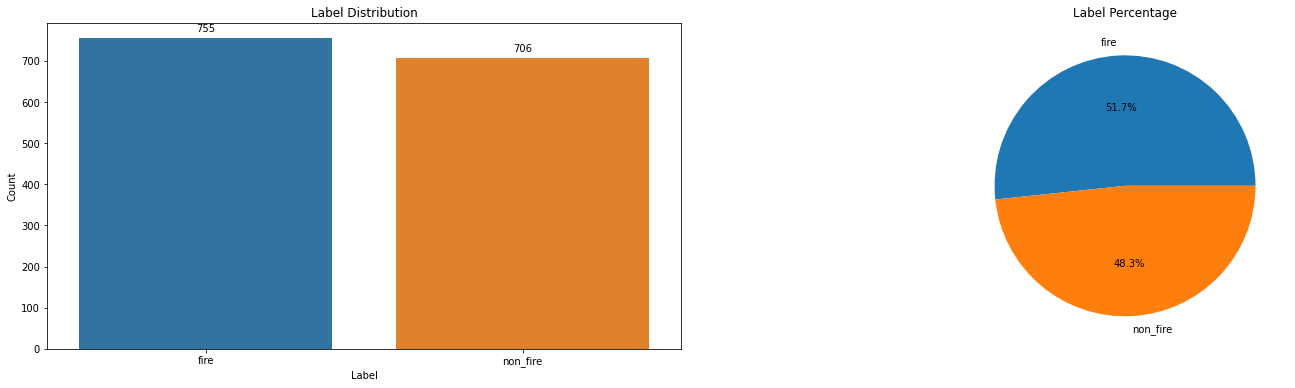

In [8]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='label', data=fire)
for p in fig.patches:
    fig.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(fire.label.value_counts(), labels=fire.label.value_counts().index, autopct='%1.1f%%')
plt.title('Label Percentage')
plt.show()

### Width and Height

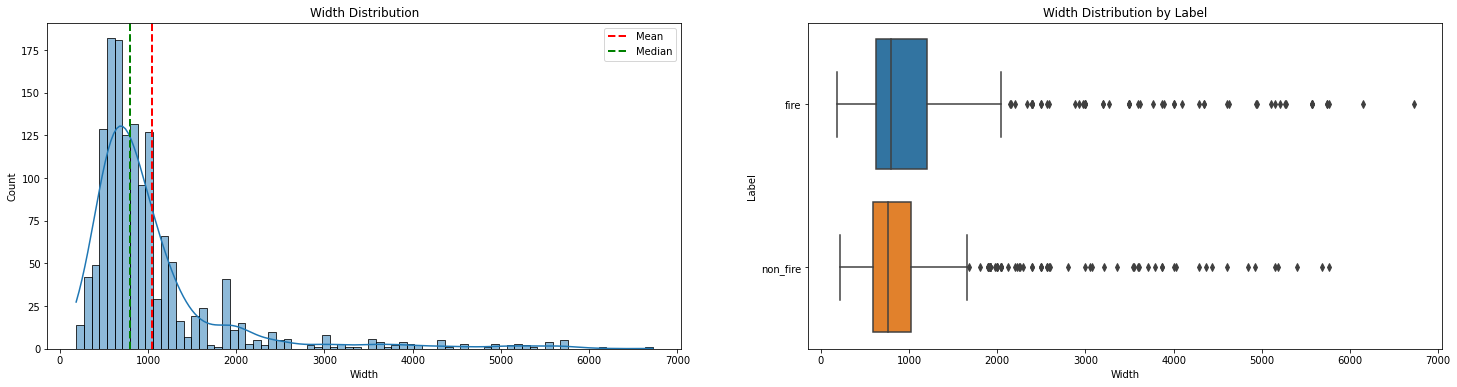

Mean: 1047
Median: 800


In [9]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='width', data=fire, kde=True)
plt.axvline(fire.width.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.width.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='width', y='label', data=fire)
plt.title('Width Distribution by Label')
plt.xlabel('Width')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.width.mean():.0f}')
print(f'Median: {fire.width.median():.0f}')

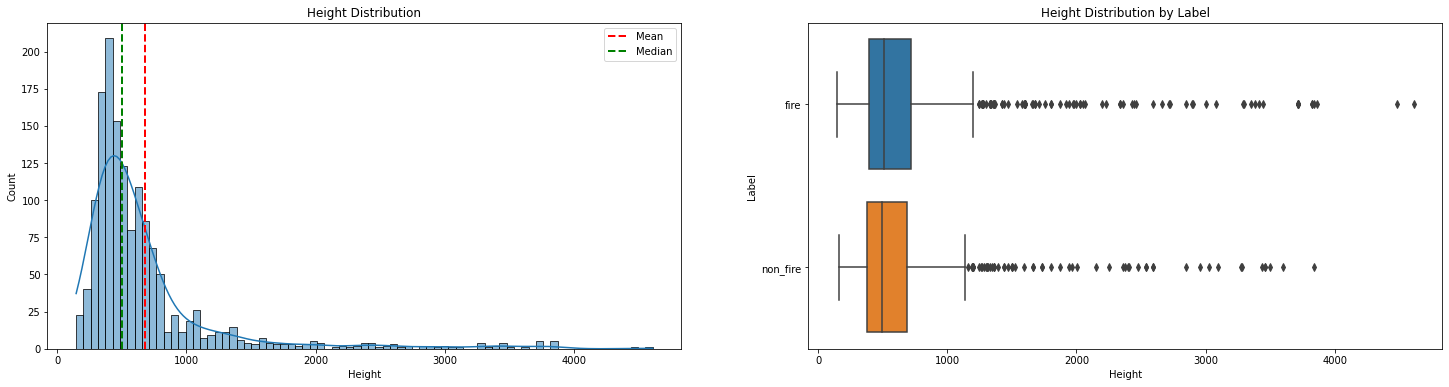

Mean: 678
Median: 500


In [10]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='height', data=fire, kde=True)
plt.axvline(fire.height.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.height.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='height', y='label', data=fire)
plt.title('Height Distribution by Label')
plt.xlabel('Height')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.height.mean():.0f}')
print(f'Median: {fire.height.median():.0f}')

### Sample Images

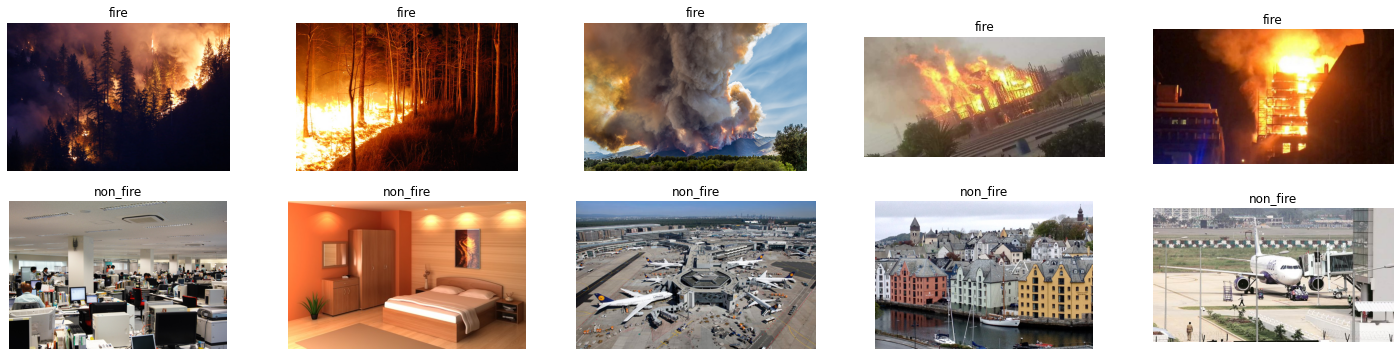

In [11]:
plt.figure(figsize=(25, 6))
counter = 1
for i in ['fire', 'non_fire']:
    for j in range(5):
        plt.subplot(2, 5, counter)
        img = image.load_img(fire[fire.label == i].iloc[j]['image'])
        plt.imshow(img)
        plt.title(i)
        plt.axis('off')
        counter += 1
plt.show()

## Data Preprocessing

In [77]:
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, width_shift_range=0.4, height_shift_range=0.4, shear_range=0.4, zoom_range=0.4)
valid_gen = ImageDataGenerator(rescale=1./255)

train_dir = 'dataset/fire_dataset/train/'
test_dir = 'dataset/fire_dataset/test/'

train_data = train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=23, class_mode='binary')
valid_data = valid_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=23, class_mode='binary')

Found 1169 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


## Model Definition

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 16)                2

## Model Training

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=valid_data)

Epoch 1/25
51/51 [==============================] - 32s 564ms/step - loss: 0.4604 - accuracy: 0.7844 - val_loss: 0.5443 - val_accuracy: 0.7637
Epoch 2/25
51/51 [==============================] - 30s 588ms/step - loss: 0.3449 - accuracy: 0.8520 - val_loss: 0.5733 - val_accuracy: 0.7671
Epoch 3/25
51/51 [==============================] - 30s 580ms/step - loss: 0.3198 - accuracy: 0.8648 - val_loss: 0.6591 - val_accuracy: 0.7842
Epoch 4/25
51/51 [==============================] - 29s 564ms/step - loss: 0.2998 - accuracy: 0.8811 - val_loss: 0.4827 - val_accuracy: 0.8082
Epoch 5/25
51/51 [==============================] - 28s 540ms/step - loss: 0.2863 - accuracy: 0.8828 - val_loss: 0.4842 - val_accuracy: 0.8219
Epoch 6/25
51/51 [==============================] - 28s 546ms/step - loss: 0.2737 - accuracy: 0.8785 - val_loss: 0.4606 - val_accuracy: 0.8014
Epoch 7/25
51/51 [==============================] - 28s 551ms/step - loss: 0.3144 - accuracy: 0.8708 - val_loss: 0.4414 - val_accuracy: 0.8116

## Model Evaluation

In [16]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.195441,0.925577,0.524495,0.832192
21,0.184367,0.925577,0.304680,0.852740
22,0.214287,0.923867,0.375884,0.825342
23,0.205721,0.923011,0.296798,0.897260
24,0.205710,0.924722,0.318152,0.880137


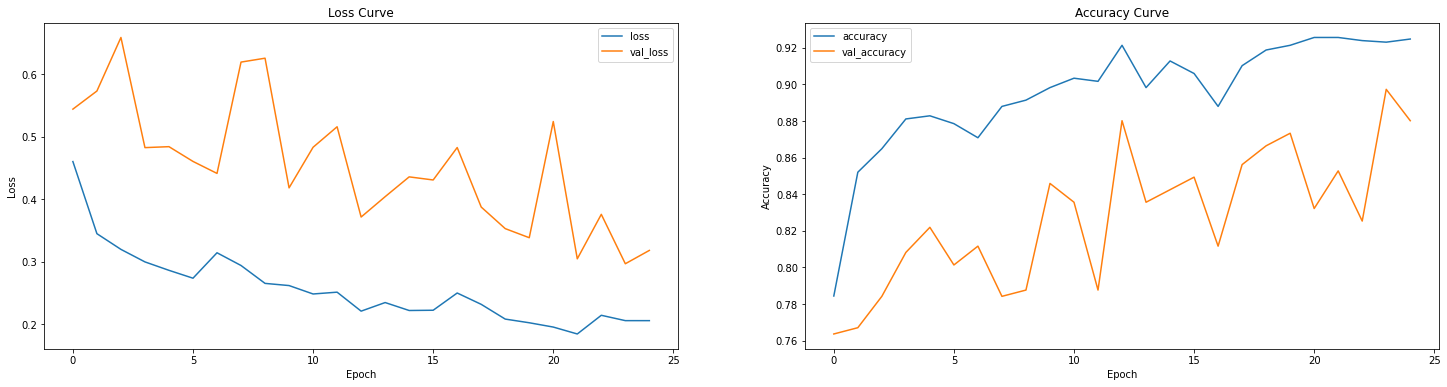

In [17]:
metrics = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

<AxesSubplot:>

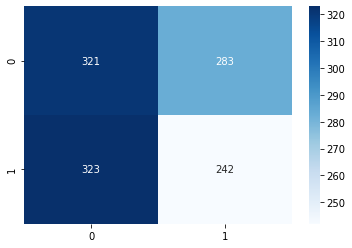

In [18]:
# Confusion Matrix
y_pred = model.predict(train_data)
y_pred = (y_pred > 0.5).astype(int)
y_true = train_data.classes

conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')

## Model Improvement

In [19]:
# Load pretrained model
pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model.trainable = False

In [172]:
tf.keras.backend.clear_session()
# Create the model
model2 = Sequential()
model2.add(pretrained_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_data, epochs=25, validation_data=train_data, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
51/51 [==============================] - 59s 1s/step - loss: 0.3187 - accuracy: 0.8794 - val_loss: 0.2131 - val_accuracy: 0.9204
Epoch 2/25
51/51 [==============================] - 56s 1s/step - loss: 0.2246 - accuracy: 0.9127 - val_loss: 0.1915 - val_accuracy: 0.9290
Epoch 3/25
51/51 [==============================] - 56s 1s/step - loss: 0.1886 - accuracy: 0.9222 - val_loss: 0.1914 - val_accuracy: 0.9239
Epoch 4/25
51/51 [==============================] - 56s 1s/step - loss: 0.1882 - accuracy: 0.9358 - val_loss: 0.1831 - val_accuracy: 0.9307
Epoch 5/25
51/51 [==============================] - 56s 1s/step - loss: 0.1856 - accuracy: 0.9307 - val_loss: 0.1696 - val_accuracy: 0.9350
Epoch 6/25
51/51 [==============================] - 56s 1s/step - loss: 0.1616 - accuracy: 0.9384 - val_loss: 0.1765 - val_accuracy: 0.9358
Epoch 7/25
51/51 [==============================] - 55s 1s/step - loss: 0.1706 - accuracy: 0.9299 - val_loss: 0.1787 - val_accuracy: 0.9324
Epoch 8/25
51/51 [==

In [173]:
print('-----------Training Results-----------')
train_results = model2.evaluate(train_data, verbose=0)
print(f'Training Loss       : {train_results[0]:.4f}')
print(f'Training Accuracy   : {train_results[1]:.4f}')

print('-----------Validation Results-----------')
validation_results = model2.evaluate(valid_data, verbose=0)
print(f'Validation Loss     : {validation_results[0]:.4f}')
print(f'Validation Accuracy : {validation_results[1]:.4f}')

-----------Training Results-----------
Training Loss       : 0.1602
Training Accuracy   : 0.9410
-----------Validation Results-----------
Validation Loss     : 0.2454
Validation Accuracy : 0.9041


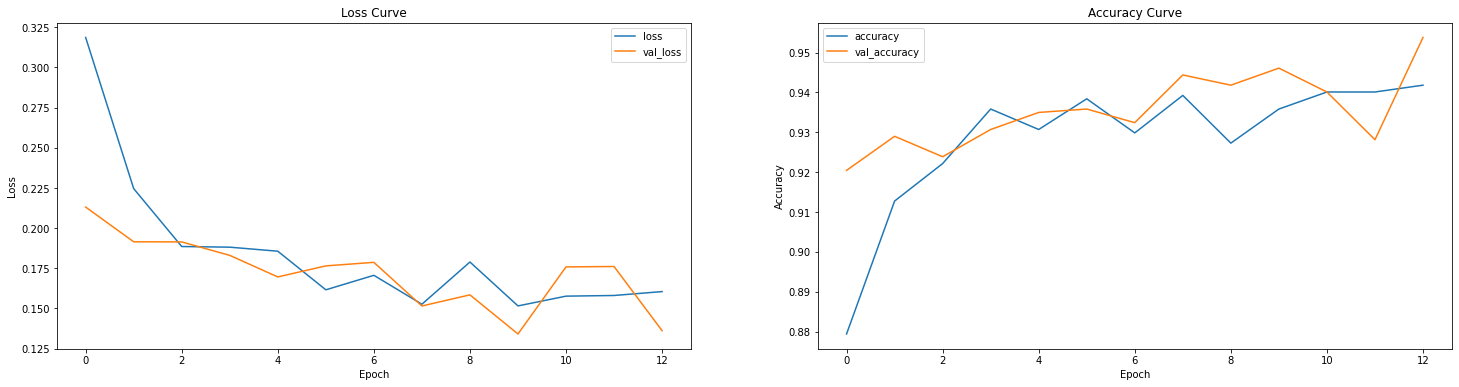

In [174]:
metrics = pd.DataFrame(history2.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

### Confusion Matrix

In [175]:
y_pred_train = tf.round(model2.predict(train_data))
y_pred_test = tf.round(model2.predict(valid_data))
y_train = train_data.classes
y_test = valid_data.classes

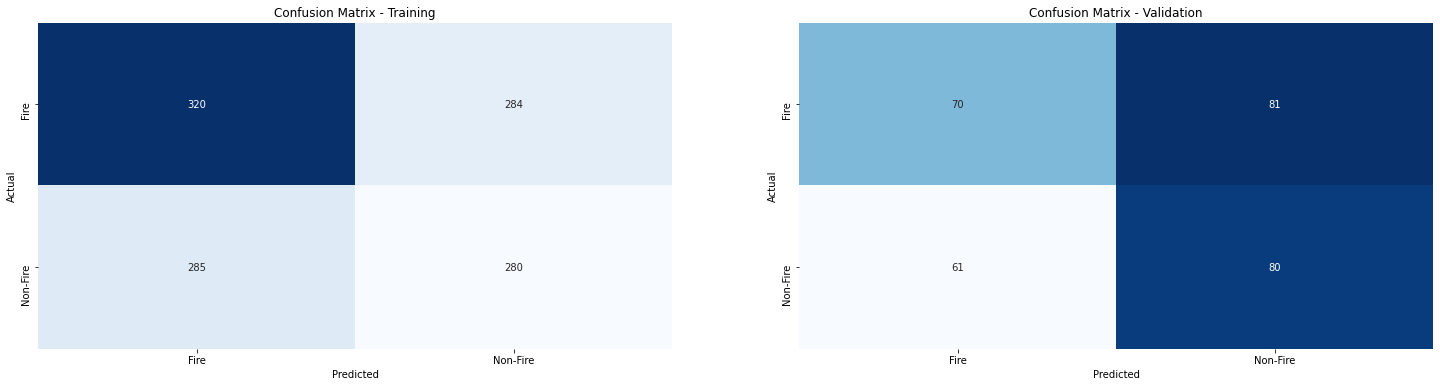

In [176]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
fig = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model Testing

In [177]:
def load_img(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

In [178]:
img1 = load_img('img1.jpg')
img2 = load_img('img2.jpg')
img3 = load_img('img3.jpg')
img4 = load_img('img4.jpg')
img5 = load_img('img5.jpg')

In [179]:
train_data.class_indices

{'fire': 0, 'non_fire': 1}

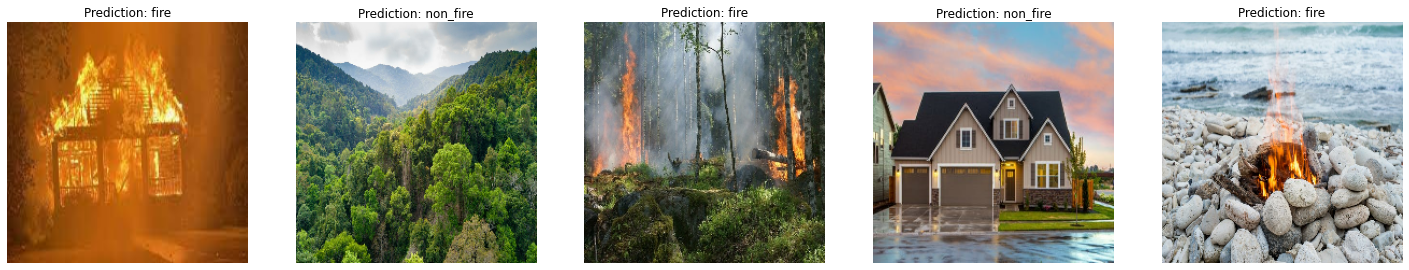

In [180]:
plt.figure(figsize=(25, 6))
counter = 1
for i in [img1, img2, img3, img4, img5]:
    plt.subplot(1, 5, counter)
    res = int(tf.round(model2.predict(x=expand_dims(i, axis=0))))
    plt.imshow(i)
    plt.title(f"Prediction: {'fire' if res == 0 else 'non_fire'}")
    plt.axis('off')
    counter += 1
plt.show()  

In [181]:
from PIL import Image
import requests
from io import BytesIO

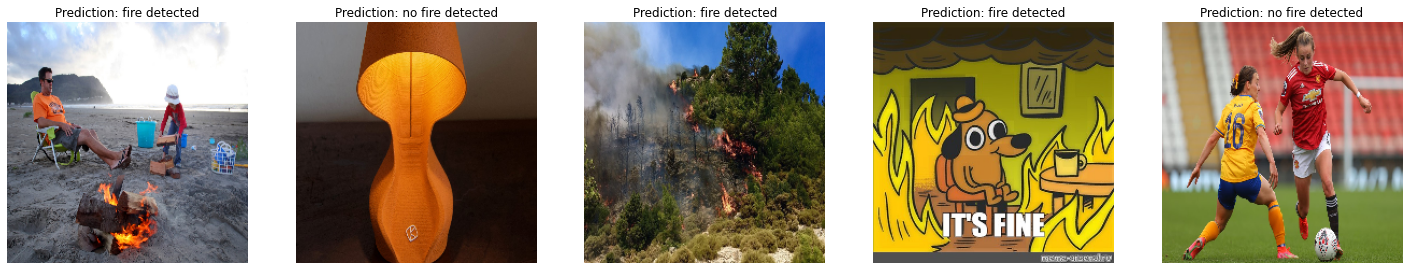

In [200]:
url = ["https://www.seasideor.com/wp-content/uploads/2018/09/201809Seaside_web_bonfire2.jpg",
       'https://c3.iggcdn.com/indiegogo-media-prod-cld/image/upload/c_fill,w_695,g_auto,q_auto,dpr_2.6,f_auto,h_460/kbfxqryt4isymijrutxc',
       'https://www.globaltimes.cn/Portals/0/attachment/2021/2021-08-02/a93da530-4a35-4ff9-8af1-786ac98b5787.jpeg',
       'https://www.meme-arsenal.com/memes/559abfdd9093d1f3f2f55ea576d03903.jpg',
       'https://cdn.vox-cdn.com/thumbor/lfp8MMMq5dEmdFu9z237jl3EhLQ=/0x0:4623x3293/1200x800/filters:focal(1943x1278:2681x2016)/cdn.vox-cdn.com/uploads/chorus_image/image/69623726/1317634572.0.jpg']
       
plt.figure(figsize=(25, 6))
for i in range(len(url)):
    response = requests.get(url[i])
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    img = resize(img, size=[224, 224])
    img = img/255.
    plt.subplot(1, len(url), i+1)
    plt.imshow(img)
    res = int(tf.round(model2.predict(x=expand_dims(img, axis=0))))
    plt.title(f"Prediction: {'fire detected' if res == 0 else 'no fire detected'}")
    plt.axis('off')
plt.show()